In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import numpy as np
from PIL import Image
import cv2
import matplotlib.image as mpimg
import os
import scipy.ndimage as ndimage

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 30

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "images",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2273 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names
class_names

['guava_diseased',
 'guava_healthy',
 'jamun_diseased',
 'jamun_healthy',
 'lemon_diseased',
 'lemon_healthy',
 'mango_diseased',
 'mango_healthy',
 'pomegranate_diseased',
 'pomegrenate_healthy']

In [5]:
# for image_batch, labels_batch in dataset.take(1):
#     #print(image_batch.shape)
#     #print(labels_batch.numpy())
    
#     for i in range(12):
#         ax = plt.subplot(3,4,i+1)
        
#         #plt.imshow(image_batch[i].numpy().astype("uint8"))
        
#         def rgb2gray(rgb):
#             return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])
        
        
#         img_gray = rgb2gray(image_batch[i])
        
#         def apply_gaussian_blur(img_gray):
#             blurred_image = tf.image.gaussian_filter2d(image, sigma=1.0)
#             return blurred_image
        
#         plt.imshow(img_gray, cmap=plt.get_cmap('gray'))
#         #plt.show()
        
#         plt.title(class_names[labels_batch[i]])
#         plt.axis("off")

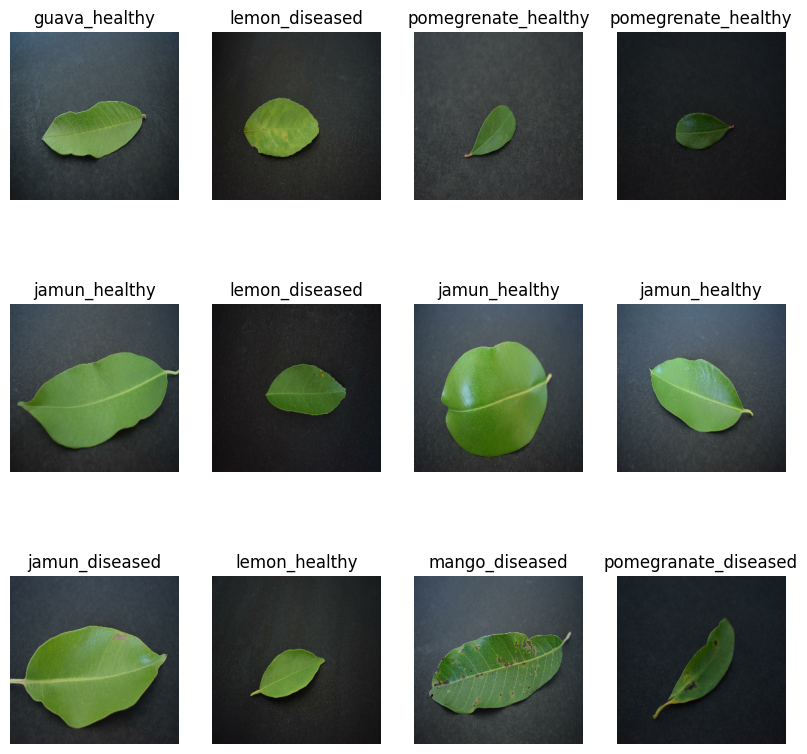

In [6]:
#Display Images

# plt.figure(figsize=(10, 10))
# for image_batch, labels_batch in dataset.take(1):
#     for i in range(12):
#         ax = plt.subplot(3, 4, i + 1)
#         plt.imshow(image_batch[i].numpy().astype("uint8"))
#         plt.title(class_names[labels_batch[i]])
#         plt.axis("off")

In [5]:
len(dataset)

72

In [6]:
train_size = 0.8
len(dataset)*train_size

57.6

In [7]:
train_ds = dataset.take(57)
len(train_ds)

57

In [8]:
test_ds = dataset.skip(57)
len(test_ds)

15

In [9]:
val_size=0.1
len(dataset)*val_size

7.2

In [10]:
val_ds = test_ds.take(7)
len(val_ds)

7

In [11]:
test_ds = test_ds.skip(7)
len(test_ds)

8

In [12]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
len(train_ds)

57

In [15]:
len(val_ds)

7

In [16]:
len(test_ds)

8

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [20]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
len(dataset)

72

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (32, 123008)             

In [24]:
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
57/57 [==============================] - 151s 1s/step - loss: 2.0260 - accuracy: 0.2812 - val_loss: 1.4347 - val_accuracy: 0.4420
Epoch 2/30
57/57 [==============================] - 40s 705ms/step - loss: 1.2503 - accuracy: 0.5263 - val_loss: 1.0066 - val_accuracy: 0.6071
Epoch 3/30
57/57 [==============================] - 40s 704ms/step - loss: 0.9718 - accuracy: 0.6310 - val_loss: 0.7375 - val_accuracy: 0.6875
Epoch 4/30
57/57 [==============================] - 40s 705ms/step - loss: 0.7770 - accuracy: 0.7204 - val_loss: 0.7724 - val_accuracy: 0.7232
Epoch 5/30
57/57 [==============================] - 40s 704ms/step - loss: 0.7665 - accuracy: 0.7056 - val_loss: 0.6345 - val_accuracy: 0.7545
Epoch 6/30
57/57 [==============================] - 40s 702ms/step - loss: 0.6224 - accuracy: 0.7664 - val_loss: 0.6778 - val_accuracy: 0.7545
Epoch 7/30
57/57 [==============================] - 40s 705ms/step - loss: 0.5750 - accuracy: 0.7862 - val_loss: 0.5326 - val_accuracy: 0.7902
E

In [26]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 28s 155ms/step - loss: 0.1246 - accuracy: 0.9570


In [28]:
scores2 = model.evaluate(train_ds)

57/57 [==============================] - 18s 304ms/step - loss: 0.2049 - accuracy: 0.9238


In [29]:
scores3 = model.evaluate(val_ds)

7/7 [==============================] - 1s 153ms/step - loss: 0.1850 - accuracy: 0.9330


In [30]:
scores

[0.12455696612596512, 0.95703125]

In [31]:
scores2

[0.20488427579402924, 0.9237938523292542]

In [32]:
scores3

[0.18496647477149963, 0.9330357313156128]

In [28]:
history

In [33]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 57}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
type(history.history['loss'])

list

In [36]:
len(history.history['loss'])

30

In [37]:
history.history['loss'][:5]

[2.0260396003723145,
 1.2503420114517212,
 0.9718165993690491,
 0.776974618434906,
 0.7664527893066406]

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

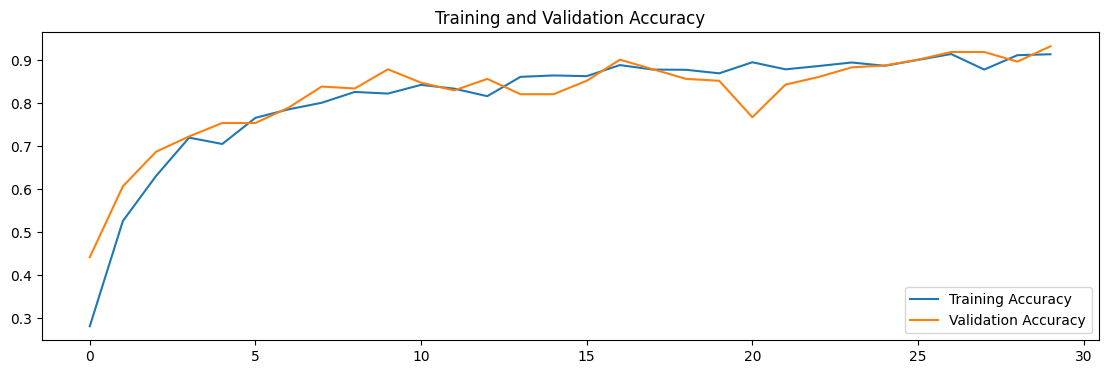

In [69]:
plt.figure(figsize=(30, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

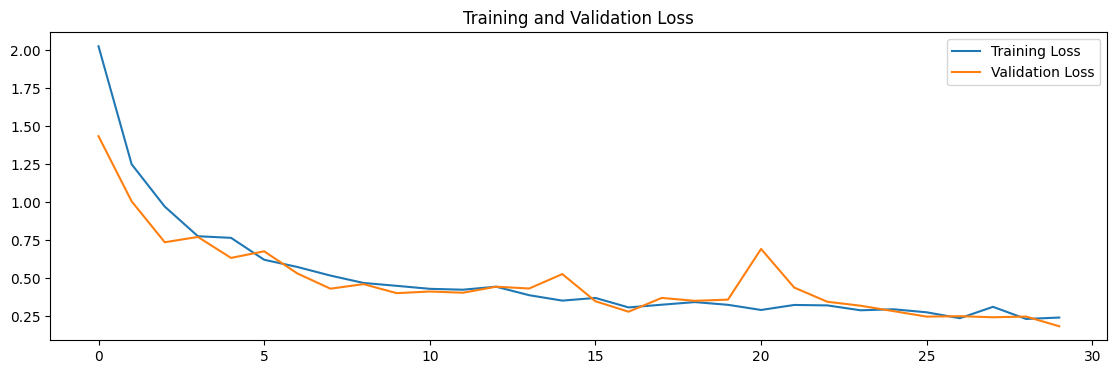

In [57]:
plt.figure(figsize=(30, 4))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: mango_diseased
1/1 [==============================] - 0s 243ms/step
predicted label: mango_diseased


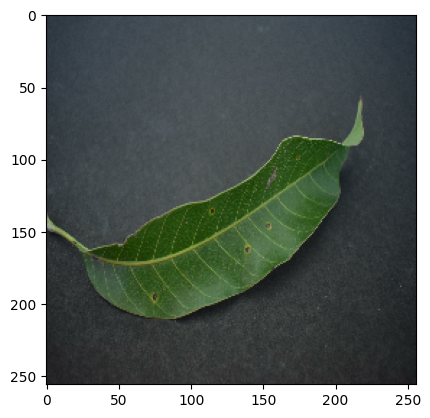

In [63]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [64]:
#Test - Accuracy curve for particular class


# class_index = 5  # Index of the desired class
# class_accuracy = history.history['accuracy'][class_index]



# epochs = EPOCHS

# plt.plot(epochs, class_accuracy, label='Class Accuracy')
# plt.title('Accuracy Curve - Class {}'.format(class_index))
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [70]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


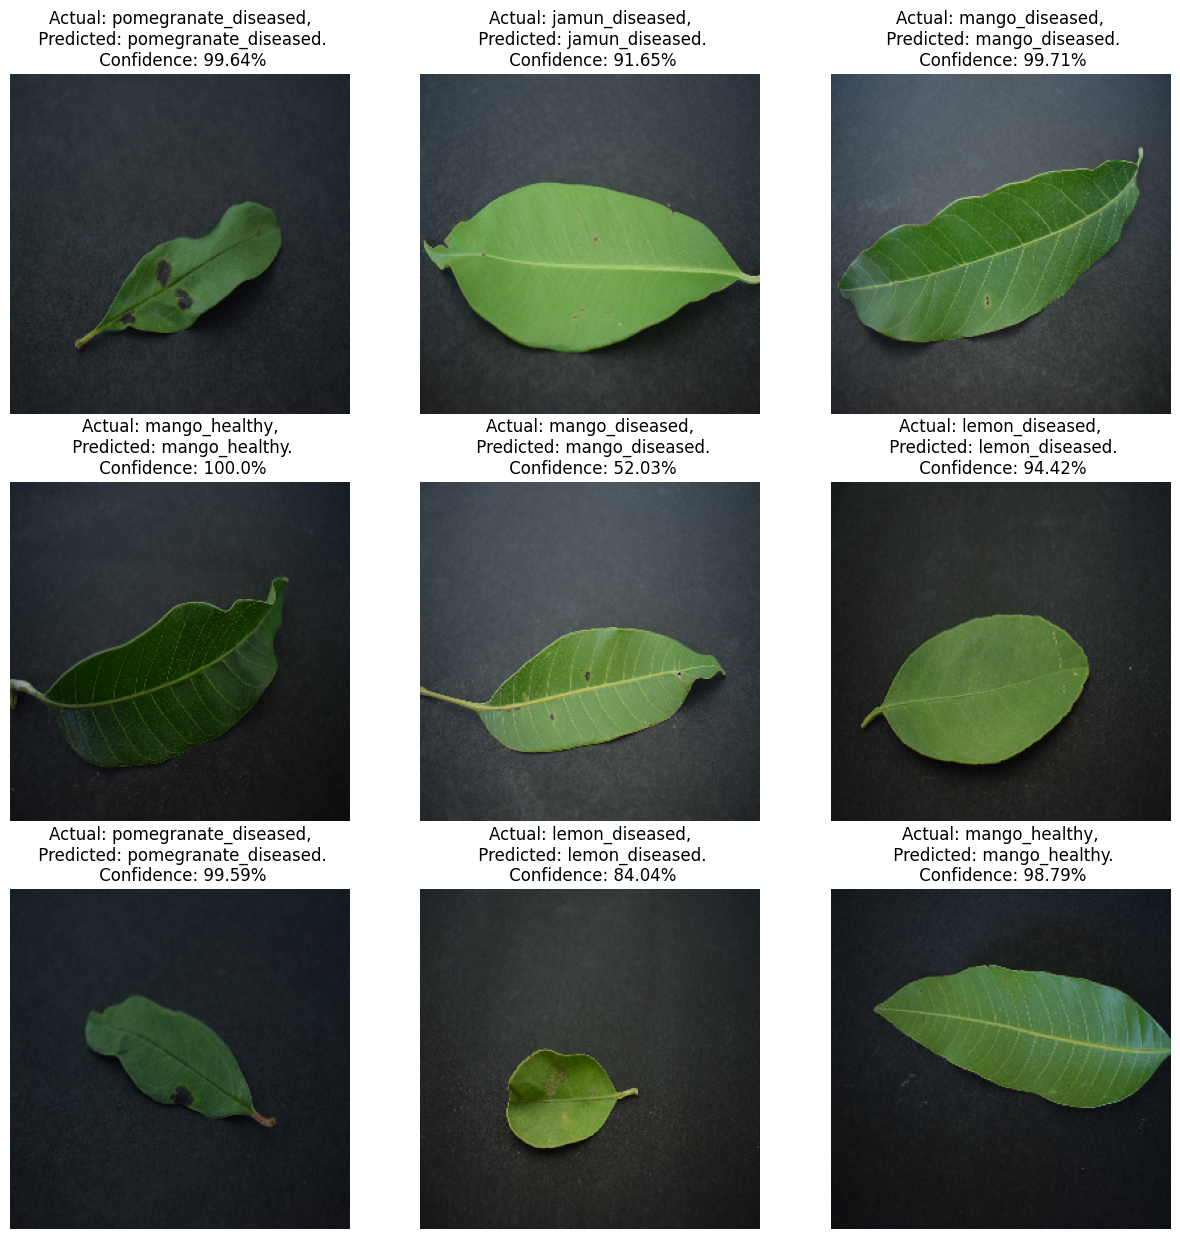

In [71]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")